# **CarND: Vehicle Detection and Tracking**

---

** Project Overview **





In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from PIL import Image
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.neural_network import MLPClassifier
from collections import deque

Now let write a function that applies a **HOG feature extraction** on a image and returns those features

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient = 11, pix_per_cell = 12, cell_per_block = 2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(16,16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(img, orient = 11, pix_per_cell = 12, cell_per_block = 2, spatial_size = (16,16), hist_bins = 32):
    img = img.astype(np.float32)/255
    
    spatial_features = bin_spatial(img, size=spatial_size)
    hist_features = color_hist(img, nbins=hist_bins)
    
    ctrans_tosearch = convert_color(img, conv='RGB2YCrCb')
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    #hog_features = np.hstack((hog1, hog2, hog3))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_features2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_features3 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_features = np.hstack((hog_features1, hog_features2, hog_features3))

    
    #print (spatial_features.shape, "Spatial Features")
    #print (hist_features.shape, "Hist Features")
    #print (hog_features1.shape, "HOG Features1")
    #print (hog_features2.shape, "HOG Features2")
    #print (hog_features3.shape, "HOG Features3")
    #print (hog_features.shape, "TOTAL HOG Features")
    
    test_features =  np.hstack((spatial_features, hist_features, hog_features))
    #print (test_features.shape, "Test Feature Shape")
    return test_features

True

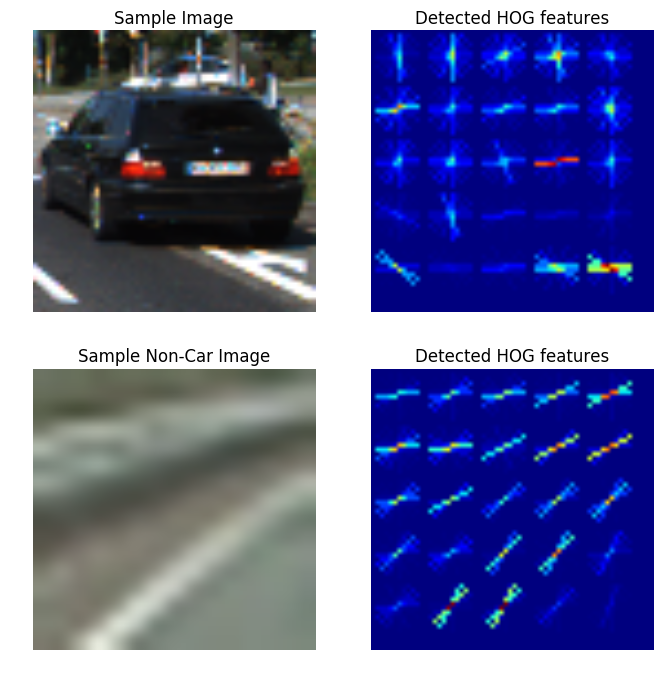

In [3]:
%matplotlib inline
test_image = mpimg.imread('test_images/111.png')
notcar_test_image = mpimg.imread('test_images/image6.png')
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
notcar_test_image_gray = cv2.cvtColor(notcar_test_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
car_features, hog_img = get_hog_features(test_image_gray, vis = True)
notcar_features, notcar_img = get_hog_features(notcar_test_image_gray, vis = True)



f, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0][0].imshow(test_image)
axs[0][0].set_title('Sample Image', fontsize=12)
axs[0][0].axis('off')
cv2.normalize(test_image, test_image, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite("output_images/test_car_image.jpg", test_image)

axs[0][1].imshow(hog_img)
axs[0][1].set_title('Detected HOG features', fontsize=12)
axs[0][1].axis('off');
cv2.normalize(hog_img, hog_img, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite("output_images/hog_img.jpg", hog_img)

axs[1][0].imshow(notcar_test_image)
axs[1][0].set_title('Sample Non-Car Image', fontsize=12)
axs[1][0].axis('off')
cv2.normalize(notcar_test_image, notcar_test_image, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite("output_images/notcar_test_image.jpg", notcar_test_image)

axs[1][1].imshow(notcar_img)
axs[1][1].set_title('Detected HOG features', fontsize=12)
axs[1][1].axis('off');
cv2.normalize(notcar_img, notcar_img, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite("output_images/notcar_img.jpg", notcar_img)

In [4]:
import pandas as pd
df = pd.read_csv("object-detection-crowdai/labels.csv")
car_features = []

for index, row in df.iterrows():
    #print (df.iloc[[index]])
    if row['Label'] == 'Car':
        img = mpimg.imread('object-detection-crowdai/' + row['Frame'])
        subimg = img[row['xmax']:row['ymax'], row['xmin']:row['ymin']]
        if subimg.shape[0] < 20 or subimg.shape[1] < 20:
            pass
            print (index, 'Image too small')
        else:
            resized_img = cv2.resize(subimg, (64,64))
            # Normalize 
            norm_img = None
            cv2.normalize(resized_img, resized_img, 0, 255, cv2.NORM_MINMAX)
            car_feature = extract_features(resized_img)
            car_features.append(car_feature)
            
    if index > 8000:
        break

3051 Image too small
5482 Image too small


In [5]:
print(len(car_features))

7506


In [6]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

#car_features = []
notcar_features = []

print('Extracting features...')
t=time.time()

for file in cars:
    image = mpimg.imread(file)
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    car_feature = extract_features(image)
    car_features.append(car_feature)

for file in notcars:
    image = mpimg.imread(file)
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    notcar_feature = extract_features(image)
    notcar_features.append(notcar_feature)
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print("Feature Lenght", car_features[0].shape)
print(len(car_features))
print(len(notcar_features))

Extracting features...
2822.31 Seconds to extract features...
Feature Lenght (2976,)
16298
8968


- (3072,) Spatial Features
- (96,) Hist Features
- (5292,) HOG Features
- (8460,) Test Features

In [7]:
print('Creating vectors and scaling...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))


print('\nTraining classifier...')

clf = MLPClassifier()
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train CLF...')

# Check the score of the CLF
print('Test Accuracy of CLF = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My CLF predicts: ', clf.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with CLF')

Creating vectors and scaling...
Feature vector length: 2976

Training classifier...
34.72 Seconds to train CLF...
Test Accuracy of CLF =  0.9929
My CLF predicts:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
0.00296 Seconds to predict 10 labels with CLF


In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,255), 2)
    # Return the image
    return img

In [9]:
test_image = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
d = deque(maxlen = 5)
# This implementation is much faster than the next one
def find_cars(this, ystart = 350, ystop = 656, scale = 1.2, orient = 11, pix_per_cell = 12, cell_per_block = 2,
              spatial_size = (16, 16), hist_bins = 32, vis = False):
    
    draw_img = np.copy(this)
    window_img = np.copy(draw_img)
    this = this.astype(np.float32)/255
    test_box_list = []
    
    img_tosearch = this[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    test_ch1 = ctrans_tosearch[:,:,0]
    test_ch2 = ctrans_tosearch[:,:,1]
    test_ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (test_ch1.shape[1] // pix_per_cell)-1
    nyblocks = (test_ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(test_ch1, feature_vec=False)
    hog2 = get_hog_features(test_ch2, feature_vec=False)
    hog3 = get_hog_features(test_ch3, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            test_hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            test_spatial_features = bin_spatial(subimg, size=spatial_size)
            test_hist_features = color_hist(subimg, nbins=hist_bins)
            
            #print(test_spatial_features.shape)
            #print(test_hist_features.shape)
            #print(test_hog_features.shape)

            # Scale features and make a prediction
            test_features1 = X_scaler.transform(np.hstack((test_spatial_features, test_hist_features, test_hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))  
            #print ('Vector Lenght; ', test_features1)
            test_prediction = clf.predict(test_features1)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if vis:
                    cv2.rectangle(window_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,255),2)
                test_box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    test_heat = np.zeros_like(this[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    test_heat = add_heat(test_heat,test_box_list)

    # Apply threshold to help remove false positives
    test_heat = apply_threshold(test_heat,3)

    # Visualize the heatmap when displaying    
    test_heatmap = np.clip(test_heat, 0, 255)
    
    if not vis:
        # Stack Heatmap
        d.append(test_heatmap)

        stacked_heatmap = np.zeros_like(test_heatmap)
        for hmap in d:
            stacked_heatmap = np.sum([stacked_heatmap, hmap], axis=0)

        # Find final boxes from heatmap using label function
        test_labels = label(stacked_heatmap)
        
    else:
        test_labels = label(test_heatmap)
    
    draw_img = draw_labeled_bboxes(draw_img, test_labels)
    
    if vis:
        return draw_img, test_labels, test_heatmap, window_img
                
    return draw_img



In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0,100,0), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color , thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
window_sizes = [70]
test_windows = []
image = mpimg.imread('test_images/test1.jpg')


for size in window_sizes:
    test_windows.extend(slide_window(image, 
                                    x_start_stop=[20, image.shape[1] - 20], 
                                    y_start_stop=[image.shape[0]//2, image.shape[0] - 50], 
                                    xy_window=(size, size), 
                                    xy_overlap=(.75, .75)))
    
print (len(test_windows))
#window_img = draw_boxes(image, test_windows, color=(255, 0, 255), thick=4) 
#wnd = test_windows[0]

#print (wnd)
#subimg = image[wnd[0][1]:wnd[1][1], wnd[0][0]:wnd[1][0]]
##resized = cv2.resize(subimg, (64, 64))
#window_img = draw_boxes(window_img, [wnd], color=(0, 255, 255), thick=6) 
#plt.subplot(211)
#plt.imshow(resized)
#plt.subplot(212)
#plt.imshow(window_img)

1207


In [20]:
test_image = mpimg.imread('test_images/test1.jpg')

# Define queue and windows for find_cars
d = deque(maxlen = 5)
window_sizes = [70]
test_windows = []

for size in window_sizes:
        test_windows.extend(slide_window(image, 
                                    x_start_stop=[20, image.shape[1] - 20], 
                                    y_start_stop=[image.shape[0]//2, image.shape[0] - 50], 
                                    xy_window=(size, size), 
                                    xy_overlap=(.75, .75)))
print (len(test_windows))

def find_cars(img, windows = test_windows, ystart = 350, ystop = 656, scale = 1.2, orient = 11, pix_per_cell = 12, cell_per_block = 2,
              spatial_size = (16, 16), hist_bins = 32, vis = False):
   
    draw_img = np.copy(img)
    window_img = np.copy(draw_img)
    #this = this.astype(np.float32)/255
    bbox_list = []
    
    for wnd in windows:
        subimg = img[wnd[0][1]:wnd[1][1], wnd[0][0]:wnd[1][0]]
        resized = cv2.resize(subimg, (64, 64))
        
        features = extract_features(resized)
           
        scaled_X = X_scaler.transform(features.reshape(1, -1))
        if clf.predict(scaled_X):
            bbox_list.append(wnd)
            if vis:
                cv2.rectangle(window_img,wnd[0], wnd[1],(255,0,255),2)       
            
    test_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    test_heat = add_heat(test_heat,bbox_list)

    # Apply threshold to help remove false positives
    if vis:
        test_heat = apply_threshold(test_heat,1)
    else:
        test_heat = apply_threshold(test_heat,4)

    # Visualize the heatmap when displaying    
    test_heatmap = np.clip(test_heat, 0, 255)
    
    if not vis:
        # Stack Heatmap
        d.append(test_heatmap)

        stacked_heatmap = np.zeros_like(test_heatmap)
        for hmap in d:
            stacked_heatmap = np.sum([stacked_heatmap, hmap], axis=0)

        # Find final boxes from heatmap using label function
        test_labels = label(stacked_heatmap)
        
    else:
        test_labels = label(test_heatmap)
    
    draw_img = draw_labeled_bboxes(draw_img, test_labels)
    
    if vis:
        return draw_img, test_labels, test_heatmap, window_img
                
    return draw_img

1207


In [21]:
print('Hi, Mark')

Hi, Mark


Processing test images...
36.125690937042236 Seconds to process test images


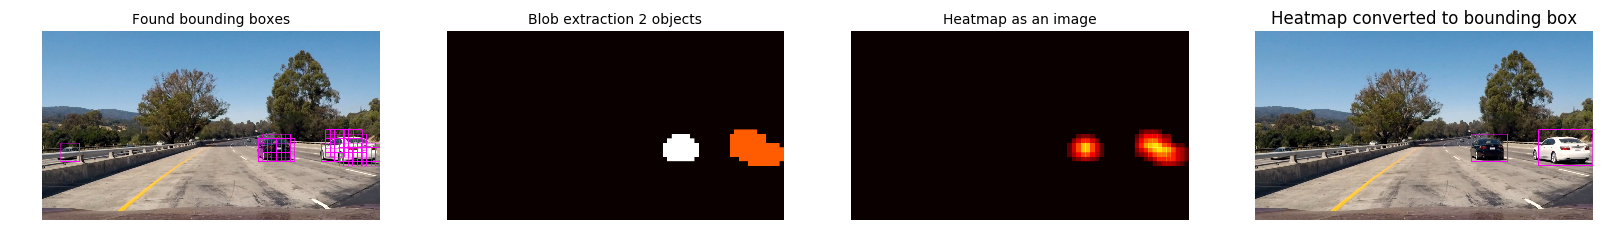

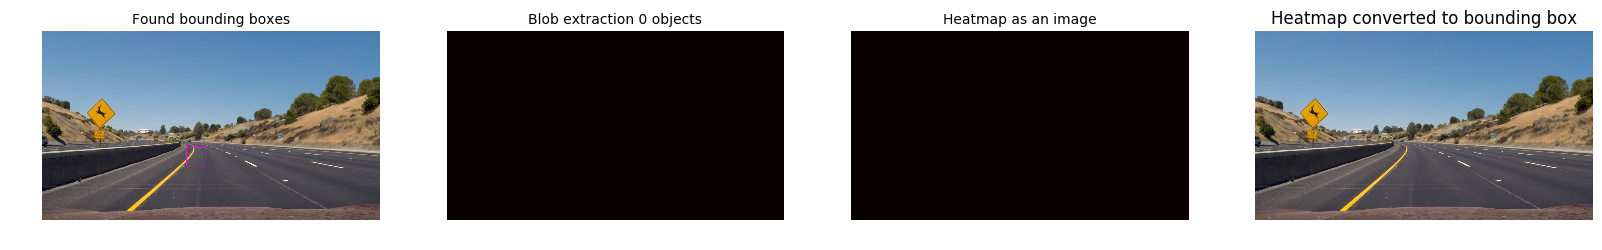

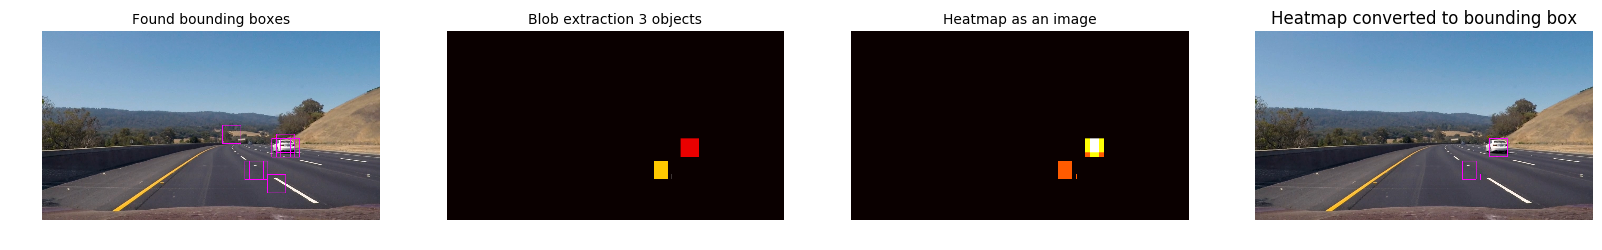

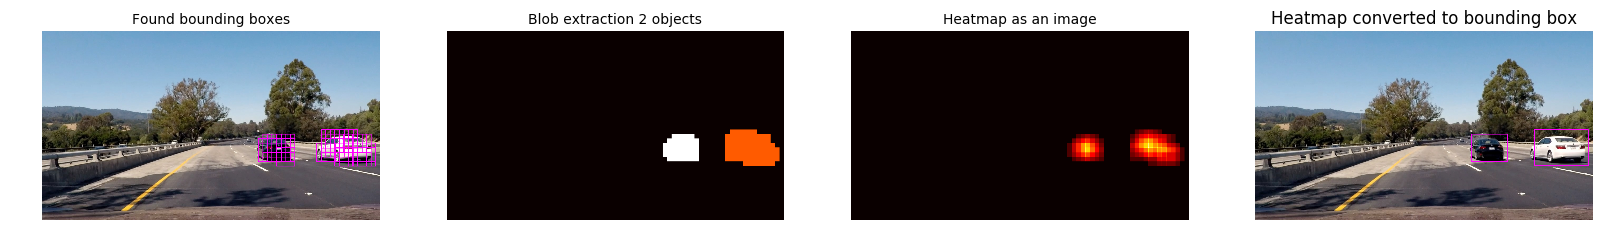

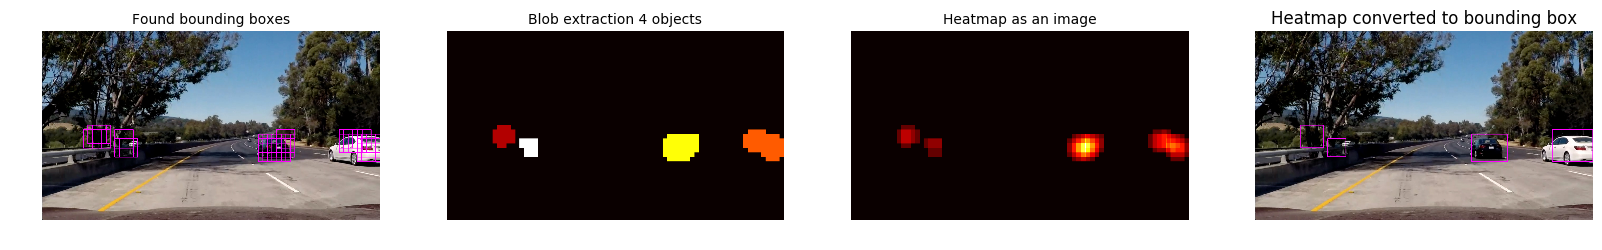

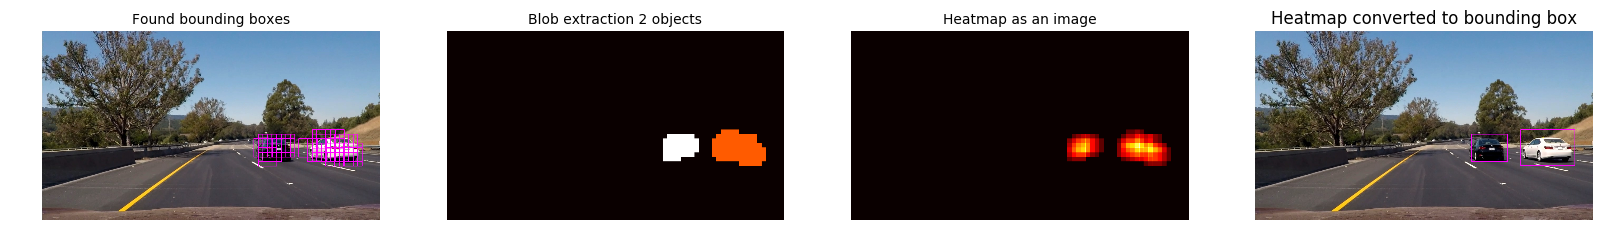

In [22]:
d = deque(maxlen = 5)
print('Processing test images...')
glob_test_images = glob.glob('test_images/*.jpg')

t1 = time.time()

for index, file in enumerate(glob_test_images):
    image = mpimg.imread(file)
    out_img, labels, heatmap, window_img, = find_cars(image, vis = True)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.imshow(window_img)
    ax1.set_title('Found bounding boxes', fontsize=10)
    ax1.axis('off')
    window_img= cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_images/window_img" + str(index) +".jpg", window_img)
    
    ax2.imshow(labels[0], cmap='hot')
    ax2.set_title('Blob extraction {} objects'.format(labels[1]), fontsize=10)
    ax2.axis('off')
    cv2.normalize(labels[0], labels[0], 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("output_images/labels.jpg" + str(index) +".jpg", labels[0])

    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heatmap as an image', fontsize=10)
    ax3.axis('off')
    cv2.normalize(heatmap, heatmap, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("output_images/heatmap.jpg" + str(index) +".jpg", heatmap)

    ax4.imshow(out_img)
    ax4.set_title('Heatmap converted to bounding box')
    ax4.axis('off')
    #window_img= cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_images/out_img.jpg" + str(index) +".jpg", out_img)
    
t2 = time.time()
print(t2-t1, 'Seconds to process test images')

# **Part 7: Search and Classify on Video ** 
---

This last part is very similar to Part 6, with the exception that the the
search and classification will be applied to each frame of the source video and the result will be a copy of the source video but with the vehicles identified by bounding boxes.

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
d = deque(maxlen = 5) # Reset the queue

output = 'output_images/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")

clip = clip1.fl_image(find_cars) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [03:13<00:05,  5.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 6min 20s, sys: 6.9 s, total: 6min 27s
Wall time: 3min 15s


In [25]:
d = deque(maxlen = 5) # Reset the queue

output = 'output_images/result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(find_cars) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/result_video.mp4
[MoviePy] Writing video output_images/result_video.mp4


100%|█████████▉| 1260/1261 [15:51:40<00:07,  7.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_video.mp4 

CPU times: user 3h 42min 41s, sys: 5min 29s, total: 3h 48min 10s
Wall time: 15h 51min 43s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))